In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from pytorchtools import EarlyStopping

In [2]:
scaler = MinMaxScaler(feature_range=(0, 1))

### 导入数据

In [3]:
df2 = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)

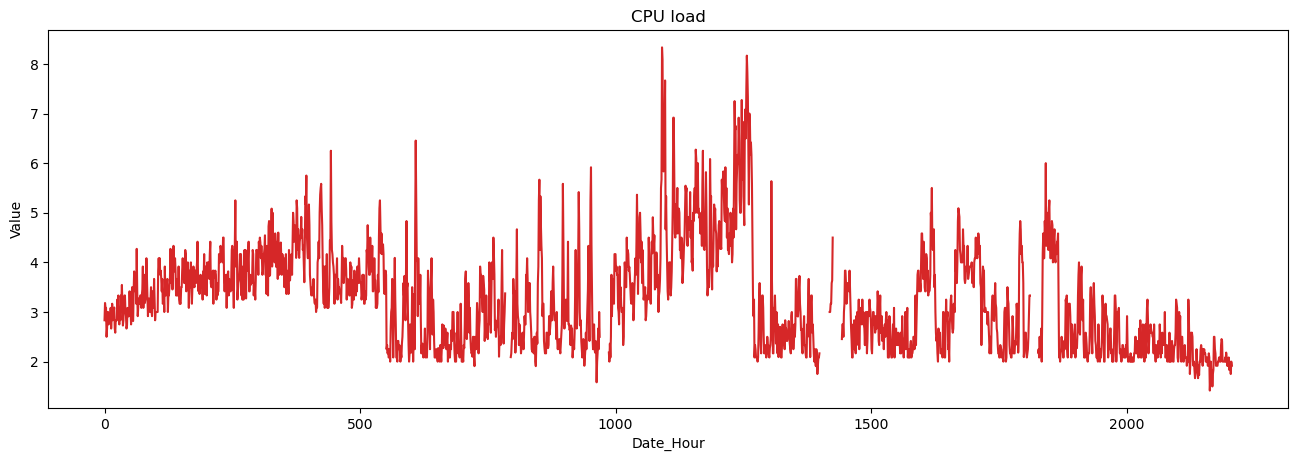

In [4]:
# Draw Plot-----绘图函数
def plot_df(df2, x, y, title="", xlabel='Date_Hour', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df2, x=df2.index, y= df2["主机CPU平均负载"], title='CPU load')

### 缺失值填充

In [5]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out
# 使用k-近邻法填补缺失值
df2["主机CPU平均负载"] = knn_mean(df2["主机CPU平均负载"], 24)

In [6]:
df = df2.copy(deep=True) 

In [7]:
# 滞后阶数
num_hour = 336
data = df["主机CPU平均负载"]
dataframe = pd.DataFrame()
for i in range(num_hour,0,-1):
    dataframe['t-'+str(i)] = data.shift(i)
dataframe['t'] = data.values
dataframe

,t-336,t-335,t-334,t-333,t-332,t-331,t-330,t-329,t-328,t-327,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8333
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8333,3.1818
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8333,3.1818,3.0833
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.8333,3.1818,3.0833,3.0833
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.8333,3.1818,3.0833,3.0833,2.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,4.5833,3.4167,2.0833,2.1667,2.0000,2.1667,2.2500,2.5000,2.2500,2.3333,...,2.0833,2.0000,2.1818,2.0833,1.9167,2.0000,1.9167,2.0833,1.8333,2.0000
2203,3.4167,2.0833,2.1667,2.0000,2.1667,2.2500,2.5000,2.2500,2.3333,2.0833,...,2.0000,2.1818,2.0833,1.9167,2.0000,1.9167,2.0833,1.8333,2.0000,1.9167
2204,2.0833,2.1667,2.0000,2.1667,2.2500,2.5000,2.2500,2.3333,2.0833,2.0833,...,2.1818,2.0833,1.9167,2.0000,1.9167,2.0833,1.8333,2.0000,1.9167,1.7500
2205,2.1667,2.0000,2.1667,2.2500,2.5000,2.2500,2.3333,2.0833,2.0833,2.4167,...,2.0833,1.9167,2.0000,1.9167,2.0833,1.8333,2.0000,1.9167,1.7500,2.0000


### 测试集和训练集

In [8]:
# all_data = dataframe[num_hour:]
# all_data = shuffle(all_data) 
# all_data.to_csv('shuffle.csv')
all_data = pd.read_csv(r"C:\Code\Python\PycharmProjects\数据分析\数据分析\shuffle.csv",index_col=0)
all_data

,t-336,t-335,t-334,t-333,t-332,t-331,t-330,t-329,t-328,t-327,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
510,3.9167,3.5833,3.5000,3.7500,3.8333,3.5833,3.8182,4.0000,4.4167,3.7500,...,3.6000,3.5833,3.2500,3.3333,3.7500,3.4167,3.7500,3.1667,3.1667,3.4167
854,3.7500,3.7500,4.5000,3.9167,3.8182,3.9167,4.3333,3.4167,3.4167,3.6667,...,2.3333,2.5833,2.3636,3.5833,3.9167,5.2500,5.6667,4.2500,5.3333,4.7500
1720,3.3333,2.5833,2.7500,2.5000,2.1667,2.0000,2.2500,2.0000,1.9091,2.2500,...,4.5000,4.1667,4.3333,3.5833,3.5000,2.3333,2.9167,3.6667,3.9167,3.8333
1564,4.0000,4.1667,5.0833,4.5000,5.9091,7.2500,6.6667,6.7500,4.6667,5.5833,...,2.5000,2.4167,2.1667,2.5833,2.1667,2.3333,2.9167,2.2500,2.3333,2.0833
526,3.6667,3.5833,3.2500,3.8182,3.6667,4.1667,3.3636,3.5000,3.9167,3.8333,...,3.9167,3.7500,3.7500,4.5000,3.9167,3.8182,3.9167,4.3333,3.4167,3.4167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,2.8333,2.3333,2.1667,2.0833,2.0833,2.5000,2.7500,2.3333,3.0833,2.0833,...,4.4167,4.4167,4.5833,3.4167,2.0833,2.1667,2.0000,2.1667,2.2500,2.5000
2055,3.9167,3.8333,3.8333,3.0000,3.0833,3.0833,3.0000,3.0000,3.0000,2.7500,...,2.5833,2.7500,2.6667,2.5833,2.5833,2.5000,2.5000,2.1667,2.7500,2.1667
1356,3.5000,3.5000,4.5000,3.9167,4.2500,4.1667,3.8333,3.9091,3.7500,3.5000,...,2.3636,2.2500,2.3333,2.7500,2.5000,2.7500,3.6667,3.6667,3.2500,2.9167
2045,4.4167,4.5833,4.5000,4.1667,4.3333,3.5833,3.5000,2.3333,2.9167,3.6667,...,2.3333,2.7500,2.0833,2.6667,3.0833,3.2500,2.8333,2.1667,2.3333,2.5833


In [9]:
var1 = int(len(all_data)*0.6)
var2 = int(len(all_data)*0.8)
train_data = all_data[0:var1]
validate_data = all_data[var1:var2]
test_data = all_data[var2:]
# train_data
# test_data
# validate_data

In [10]:
max_value = max(train_data.max().values)
min_value = min(train_data.min().values)
ch = max_value - min_value

### 归一化

In [11]:
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
train_data_normalized = train_data_normalized.reshape(-1,num_hour+1)
train_data_normalized.shape

(1122, 337)

In [12]:
validate_data_normalized = scaler.transform(validate_data.values.reshape(-1, 1))
validate_data_normalized = validate_data_normalized.reshape(-1,num_hour+1)
validate_data_normalized.shape

(374, 337)

In [13]:
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))
test_data_normalized = test_data_normalized.reshape(-1,num_hour+1)
test_data_normalized.shape

(375, 337)

In [14]:
train_X = torch.Tensor(train_data_normalized[:,0:-1].reshape(-1, 1, 336))
train_Y = torch.Tensor(train_data_normalized[:,-1].reshape(-1, 1, 1))
train_Y.shape

torch.Size([1122, 1, 1])

In [15]:
validate_X = torch.Tensor(validate_data_normalized[:,0:-1].reshape(-1, 1, 336))
validate_Y = torch.Tensor(validate_data_normalized[:,-1].reshape(-1, 1, 1))
validate_X.shape

torch.Size([374, 1, 336])

In [16]:
test_X = torch.Tensor(test_data_normalized[:,0:-1].reshape(-1, 1, 336))
test_Y = torch.Tensor(test_data_normalized[:,-1].reshape(-1, 1, 1))
test_X.shape

torch.Size([375, 1, 336])

In [17]:
# train_data_temp = torch.utils.data.TensorDataset(train_X, train_Y)
# test_data_temp = torch.utils.data.TensorDataset(test_X, test_Y)
# train_data = DataLoader(train_data_temp, batch_size=256, shuffle=True, num_workers=1)#训练数据
# test_data = DataLoader(test_data_temp, batch_size=256, shuffle=False, num_workers=2)#测试数据

### 建立AE模型

In [18]:
start = time.time()

In [19]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # [b, 336] => [b, 20]
        self.encoder = nn.Sequential(
            nn.Linear(336, 256),
            nn.ReLU(),
            nn.Linear(256, 84),
            nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU()
        )
        # [b, 20] => [b, 336]
        self.decoder = nn.Sequential(
#             nn.Linear(64, 128),
#             nn.ReLU(),
            nn.Linear(84, 256),
            nn.ReLU(),
            nn.Linear(256, 336),
            nn.Sigmoid()
        )
    def forward(self, x):
        """
        :param x: [b, 1, 336]
        :return:
        """
        batchsz = x.size(0)
        # flatten
        x = x.view(batchsz, 336)
        # encoder
        x_en = self.encoder(x)
        # decoder
        x = self.decoder(x_en)
        # reshape
        x = x.view(batchsz, 1, 336)
        return x,x_en
    
model_AE = AE()
model_AE

AE(
  (encoder): Sequential(
    (0): Linear(in_features=336, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=84, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=84, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=336, bias=True)
    (3): Sigmoid()
  )
)

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_AE.parameters(), lr=1e-3)
epoch_n = 1500
# # 初始化 early_stopping 对象
# # 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
# patience = 100  

# # 关于 EarlyStopping 的代码可先看博客后面的内容
# early_stopping = EarlyStopping(patience, verbose=True)

In [21]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(1, epoch_n+1):
    var_x = Variable(train_X)
#     var_y = Variable(train_Y)
    # 前向传播
    out,out_hat = model_AE(var_x)
    loss = criterion(out, var_x)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 10 == 0: # 每 10 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e, loss.item()))
    ep.append(e)
    losses.append(loss.item())
    
#     valid_output,valid_output_hat = model_AE(validate_X)
#     valid_loss = criterion(valid_output, validate_X)
    
#     early_stopping(valid_loss, model_AE)
    
#     # 若满足 early stopping 要求
#     if early_stopping.early_stop:
#         print("Early stopping")
#         # 结束模型训练
#         break

print('Finished Training') 

Epoch: 10, Loss: 0.03591
Epoch: 20, Loss: 0.03026
Epoch: 30, Loss: 0.02955
Epoch: 40, Loss: 0.02845
Epoch: 50, Loss: 0.02739
Epoch: 60, Loss: 0.02623
Epoch: 70, Loss: 0.02486
Epoch: 80, Loss: 0.02324
Epoch: 90, Loss: 0.02105
Epoch: 100, Loss: 0.01764
Epoch: 110, Loss: 0.01589
Epoch: 120, Loss: 0.01425
Epoch: 130, Loss: 0.01342
Epoch: 140, Loss: 0.01297
Epoch: 150, Loss: 0.01267
Epoch: 160, Loss: 0.01290
Epoch: 170, Loss: 0.01255
Epoch: 180, Loss: 0.01223
Epoch: 190, Loss: 0.01202
Epoch: 200, Loss: 0.01190
Epoch: 210, Loss: 0.01171
Epoch: 220, Loss: 0.01144
Epoch: 230, Loss: 0.01114
Epoch: 240, Loss: 0.01111
Epoch: 250, Loss: 0.01089
Epoch: 260, Loss: 0.01063
Epoch: 270, Loss: 0.01033
Epoch: 280, Loss: 0.01000
Epoch: 290, Loss: 0.00977
Epoch: 300, Loss: 0.00983
Epoch: 310, Loss: 0.00944
Epoch: 320, Loss: 0.00927
Epoch: 330, Loss: 0.00910
Epoch: 340, Loss: 0.00896
Epoch: 350, Loss: 0.00886
Epoch: 360, Loss: 0.00867
Epoch: 370, Loss: 0.00851
Epoch: 380, Loss: 0.00848
Epoch: 390, Loss: 0.0

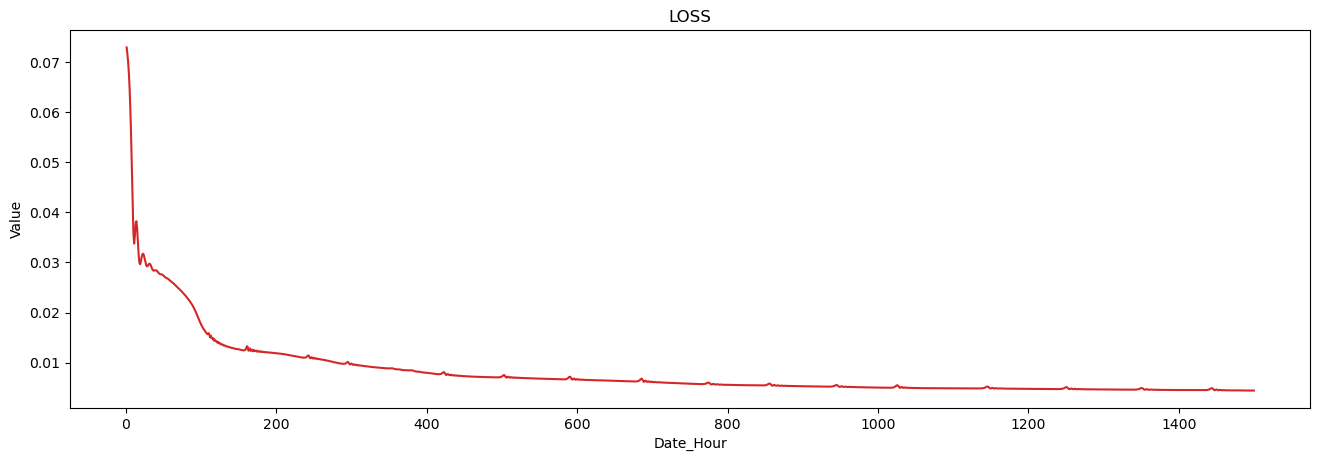

In [22]:
plot_df(df, x=ep, y= losses, title='LOSS')

In [23]:
torch.save(model_AE, 'AE_net.pkl')
model_AE2 = torch.load('AE_net.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type AE. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [24]:
def rereal(list_temp, min_value, max_value):
    arr = []
    for dat in list_temp:
        temp = dat*(max_value-min_value) + min_value
        arr.append(temp)
    return arr

In [25]:
outputs, outputs_hat = model_AE2(train_X)
train_X2 = outputs_hat.reshape(-1,14,6)
train_X2.shape

torch.Size([1122, 14, 6])

In [26]:
outputs, outputs_hat = model_AE2(validate_X)
validate_X2 = outputs_hat.reshape(-1,14,6)
validate_X2.shape

torch.Size([374, 14, 6])

In [27]:
outputs, outputs_hat = model_AE2(test_X)
test_X2 = outputs_hat.reshape(-1,14,6)
test_X2.shape

torch.Size([375, 14, 6])

### 建立LSTM模型

In [28]:
class lstm(nn.Module):
    def __init__(self,input_size=16,hidden_size=100,output_size=1,num_layer=2):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer,batch_first=True)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
        x = x[:,[13],:]
        b, s, h = x.size()
        x = x.view(-1,h)
        x = self.layer2(x)
        x = x.view(b, s, -1)
        return x

model_lstm = lstm(6, 64, 1, 2)
model_lstm

lstm(
  (layer1): LSTM(6, 64, num_layers=2, batch_first=True)
  (layer2): Linear(in_features=64, out_features=1, bias=True)
)

In [29]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-2)
epoch_n = 1000
# 初始化 early_stopping 对象
# 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
patience = 30  

# 关于 EarlyStopping 的代码可先看博客后面的内容
early_stopping = EarlyStopping(patience, verbose=True)

In [30]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(1, epoch_n+1):
    var_x = Variable(train_X2)
    var_y = Variable(train_Y)
    # 前向传播
    out = model_lstm(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 10 == 0: # 每 10 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e, loss.item()))
    ep.append(e)
    losses.append(loss.item())
    
    valid_output = model_lstm(validate_X2)
    valid_loss = criterion(valid_output, validate_Y)
    
    early_stopping(valid_loss, model_lstm)
    
    # 若满足 early stopping 要求
    if early_stopping.early_stop:
        print("Early stopping")
        # 结束模型训练
        break
    
#     break
#     if (e+1)%120 == 0:
#         for p in optimizer.param_groups:
#             p['lr'] *= 0.1
#     lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

print('Finished Training') 

Validation loss decreased (inf --> 0.024542).  Saving model ...
Validation loss decreased (0.024542 --> 0.021866).  Saving model ...
EarlyStopping counter: 1 out of 30
Validation loss decreased (0.021866 --> 0.021514).  Saving model ...
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
Validation loss decreased (0.021514 --> 0.020753).  Saving model ...
EarlyStopping counter: 1 out of 30
Validation loss decreased (0.020753 --> 0.020083).  Saving model ...
Epoch: 10, Loss: 0.02260
EarlyStopping counter: 1 out of 30
Validation loss decreased (0.020083 --> 0.019753).  Saving model ...
Validation loss decreased (0.019753 --> 0.018561).  Saving model ...
Validation loss decreased (0.018561 --> 0.018078).  Saving model ...
Validation loss decreased (0.018078 --> 0.017607).  Saving model ...
Validation loss decreased (0.017607 --> 0.016378).  Saving model ...
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
EarlyStopp

Epoch: 170, Loss: 0.00621
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
EarlyStopping counter: 4 out of 30
EarlyStopping counter: 5 out of 30
EarlyStopping counter: 6 out of 30
EarlyStopping counter: 7 out of 30
EarlyStopping counter: 8 out of 30
EarlyStopping counter: 9 out of 30
EarlyStopping counter: 10 out of 30
Epoch: 180, Loss: 0.00629
Validation loss decreased (0.005928 --> 0.005760).  Saving model ...
Validation loss decreased (0.005760 --> 0.005707).  Saving model ...
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
EarlyStopping counter: 4 out of 30
EarlyStopping counter: 5 out of 30
EarlyStopping counter: 6 out of 30
EarlyStopping counter: 7 out of 30
EarlyStopping counter: 8 out of 30
Epoch: 190, Loss: 0.00588
EarlyStopping counter: 9 out of 30
EarlyStopping counter: 10 out of 30
EarlyStopping counter: 11 out of 30
EarlyStopping counter: 12 out of 30
EarlyStopp

In [31]:
end = time.time()

In [32]:
time = end - start
print(f'运行时长为:{int(time)}s')

运行时长为:286s


In [33]:
# plot_df(df, x=range(epoch_n), y= lr_list, title='LOSS')

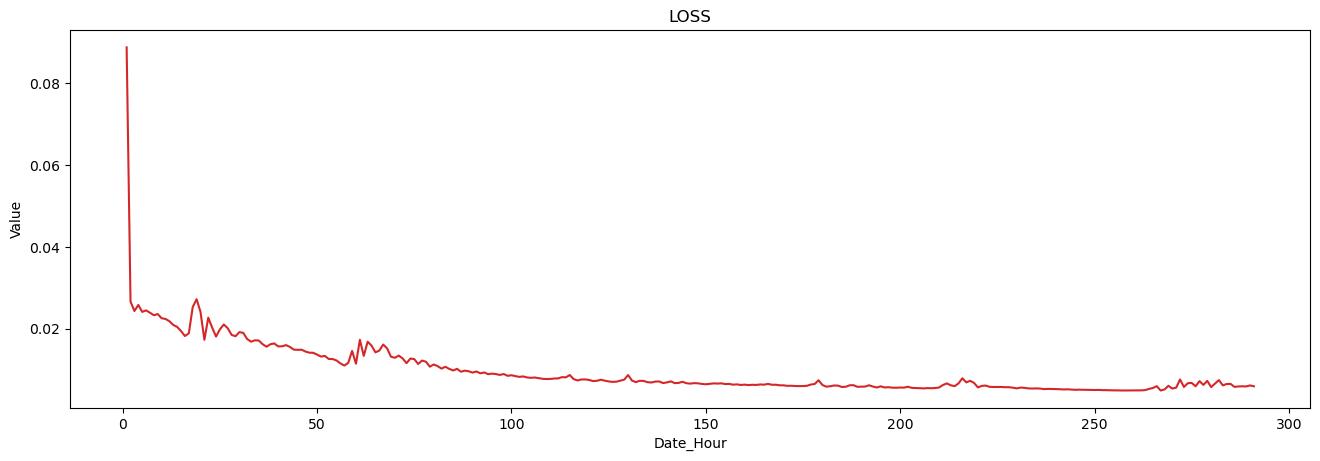

In [34]:
plot_df(df, x=ep, y= losses, title='LOSS')

In [35]:
torch.save(model_lstm, 'net.pkl')
model_lstm2 = torch.load('net.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


### 验证测试集

In [36]:
def rereal(list_temp, min_value, max_value):
    arr = []
    for dat in list_temp:
        temp = dat*(max_value-min_value) + min_value
        arr.append(temp)
    return arr

In [37]:
outputs = model_lstm2(test_X2)
loss = criterion(outputs, test_Y)
loss

tensor(0.0049, grad_fn=<MseLossBackward>)

In [38]:
outputs_hat.shape

torch.Size([375, 84])

In [39]:
num = len(test_Y)

In [40]:
outputs = outputs.reshape(num)
y_pred_temp = outputs.detach().numpy()
tru_temp = test_Y.detach().numpy().reshape(num)
# # 二维转一维
# y_pred = []
# for i in range(len(y_pred_temp)):
#     y_pred.append(y_pred_temp[i])
# test_Y = test_Y.reshape(num)

In [41]:
MSE = 0
for i in range(num):
    MSE += (y_pred_temp[i] - tru_temp[i])**2
MSE /= num
MSE

0.0048875334681305746

In [42]:
predict = rereal(y_pred_temp,min_value,max_value)
truth =  rereal(tru_temp,min_value,max_value)

In [43]:
# # 未还原归一化
# plt.figure(figsize=(16,5), dpi=100)
# plt.plot(range(num), y_pred, c='red', lw='1')
# plt.plot(range(num), tru_temp, c='blue', lw='1')

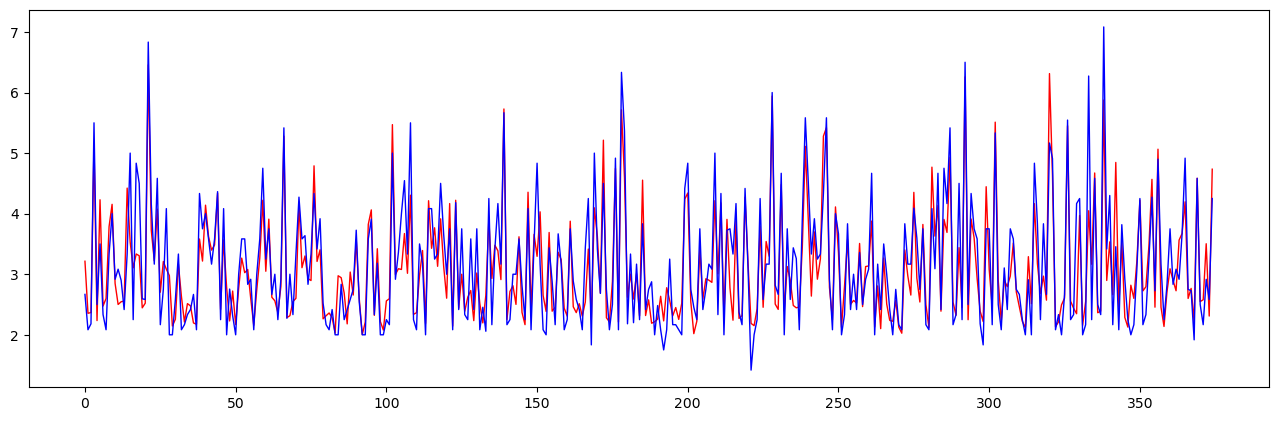

In [44]:
# 还原归一化
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), predict, c='red', lw='1')
plt.plot(range(num), truth, c='blue', lw='1')

In [45]:
# 求真实值与预测值的MSE
MSE = 0
for i in range(num):
    MSE += (predict[i] - truth[i])**2
MSE /= num
MSE

0.23381645232715106

(0.0, 3.0)

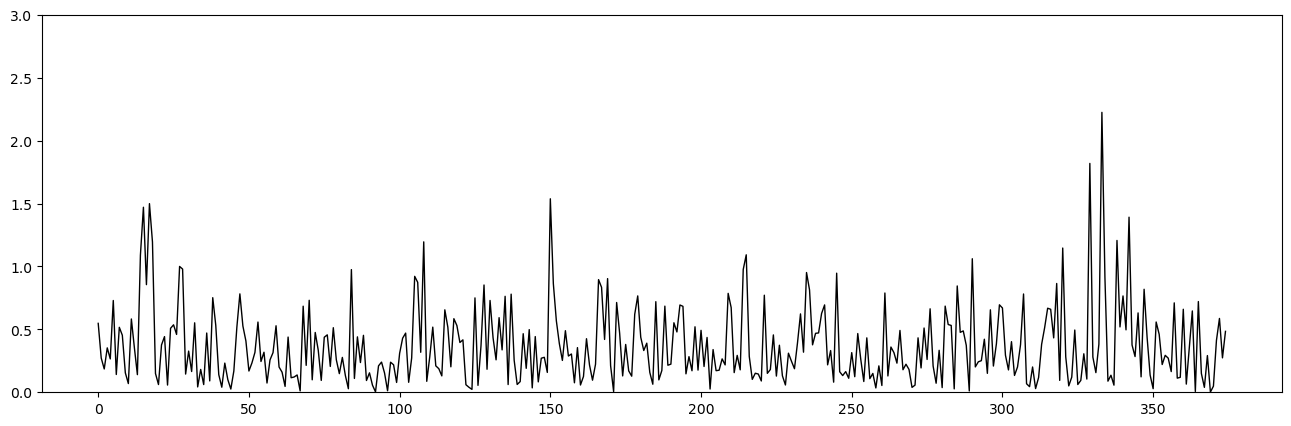

In [46]:
# 求真实值与预测值的误差值
errors = []
for i in range(num):
    error = abs(truth[i] - predict[i])
    errors.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors, c='black', lw='1')
plt.ylim(0,3)

(0.0, 70.0)

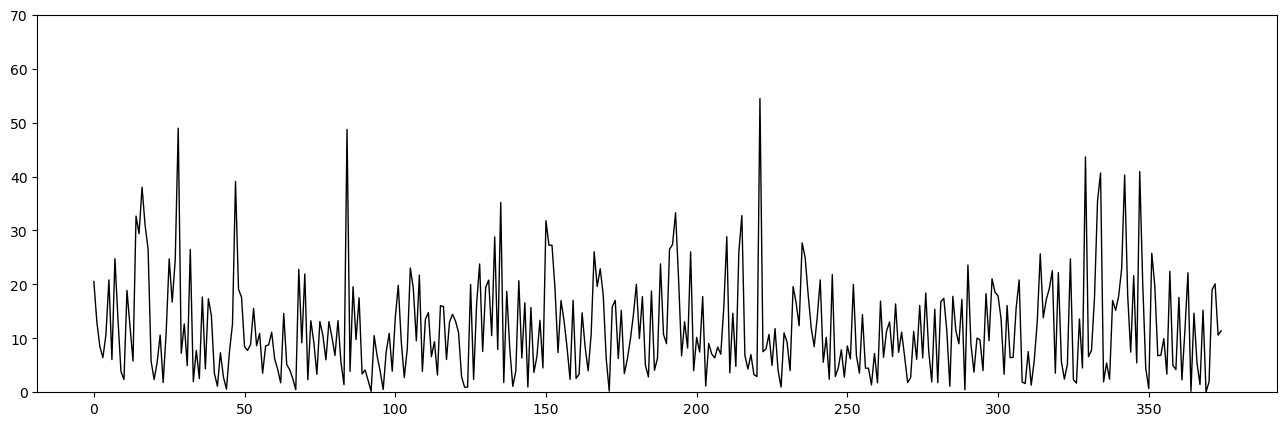

In [47]:
# 求真实值与预测值的误差值占原真实值的百分比
errors_p = []
for i in range(num):
    error = ((abs(truth[i] - predict[i]))/truth[i])*100
    errors_p.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors_p, c='black', lw='1')
plt.ylim(0,70)

In [48]:
from numpy import mean
mean(errors_p)

11.94030632001778

### 验证训练集

In [49]:
outputs = model_lstm2(train_X2)
loss = criterion(outputs, train_Y)
loss

tensor(0.0061, grad_fn=<MseLossBackward>)

In [50]:
num = len(train_Y)

In [51]:
outputs = outputs.reshape(num)
y_pred_temp = outputs.detach().numpy()
tru_temp = train_Y.detach().numpy().reshape(num)

In [52]:
MSE = 0
for i in range(num):
    MSE += (y_pred_temp[i] - tru_temp[i])**2
MSE /= num
MSE

0.00609925733921211

In [53]:
predict = rereal(y_pred_temp,min_value,max_value)
truth =  rereal(tru_temp,min_value,max_value)

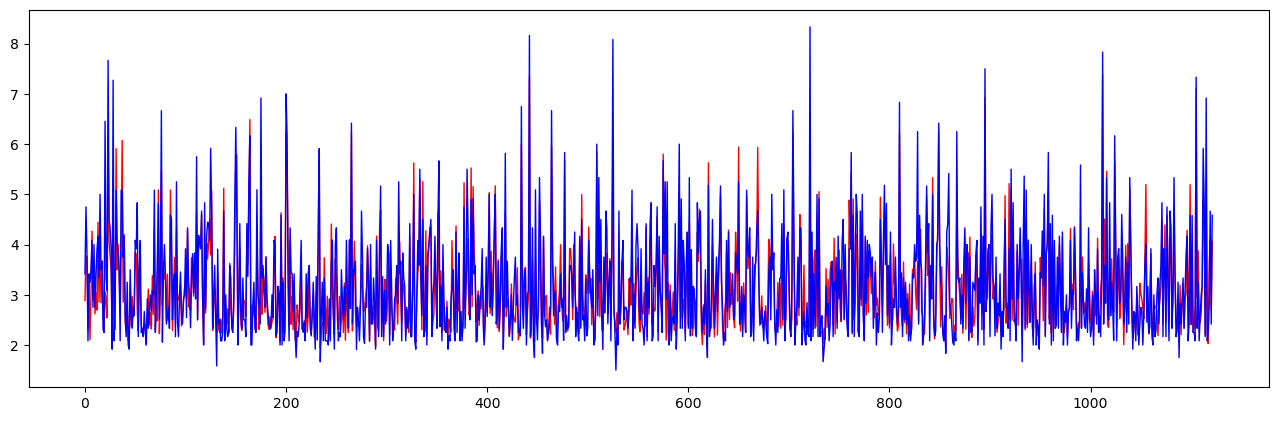

In [54]:
# 还原归一化
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), predict, c='red', lw='1')
plt.plot(range(num), truth, c='blue', lw='1')

In [55]:
# 求真实值与预测值的MSE
MSE = 0
for i in range(num):
    MSE += (predict[i] - truth[i])**2
MSE /= num
MSE

0.2917845407569391

(0.0, 3.0)

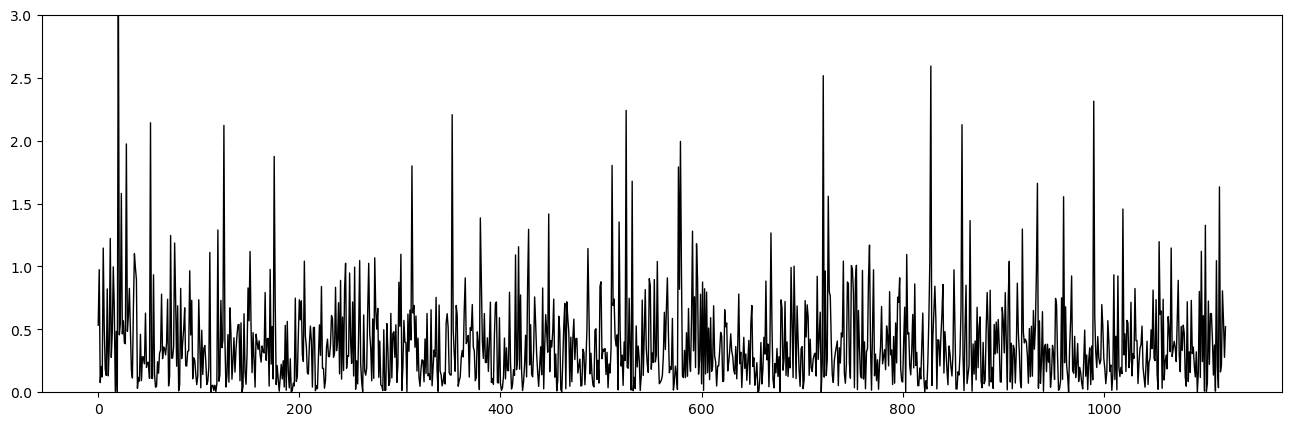

In [56]:
# 求真实值与预测值的误差值
errors = []
for i in range(num):
    error = abs(truth[i] - predict[i])
    errors.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors, c='black', lw='1')
plt.ylim(0,3)

(0.0, 70.0)

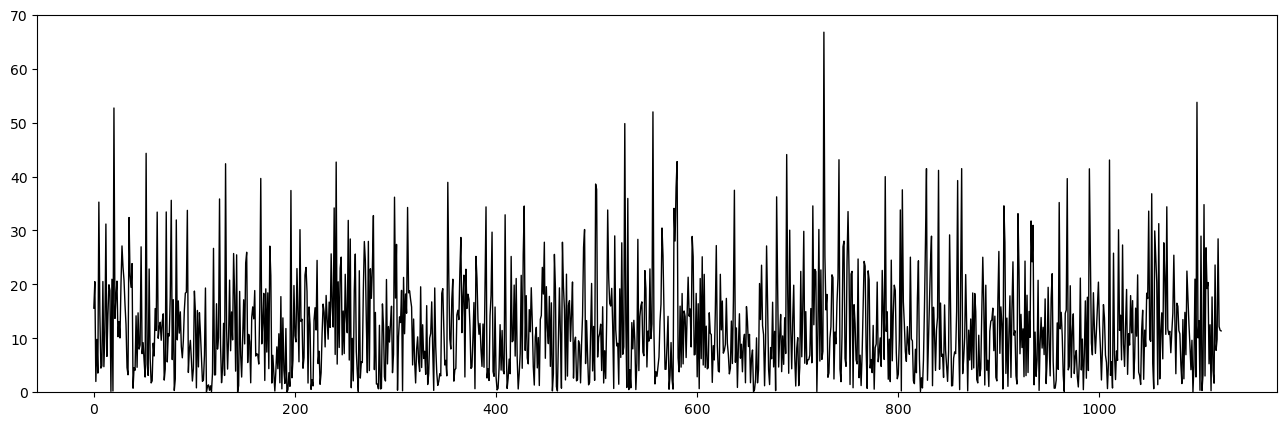

In [57]:
# 求真实值与预测值的误差值占原真实值的百分比
errors_p = []
for i in range(num):
    error = ((abs(truth[i] - predict[i]))/truth[i])*100
    errors_p.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors_p, c='black', lw='1')
plt.ylim(0,70)

In [58]:
mean(errors_p)

12.213040106001722